In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

def Cross_Validation(data, features, target, model_type, params):

    # Extract features (X) and target (y) as NumPy arrays
    X = data[features].values
    y = data[target].values

    # K-Fold setup
    kf = KFold(n_splits=5, random_state=15, shuffle=True)

    # Lists to store predictions and ground truths
    pred_list = []
    gt_list = []

    # Perform K-Fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]

        # Initialize and train the model
        model = model_type(**params)
        model.fit(X_train, y_train)

        # Predict and store results
        pred = model.predict(X_valid)
        pred_list.append(pd.DataFrame(pred, columns=["Predictions"]))
        gt_list.append(pd.DataFrame(y_valid, columns=["Ground Truth"]))

    # Concatenate ground truths and predictions
    gt_df = pd.concat(gt_list, ignore_index=True)
    pred_df = pd.concat(pred_list, ignore_index=True)

    return gt_df, pred_df


In [3]:
overall_median_approach_results=pd.read_csv('/content/drive/MyDrive/Data/regression_model_results_overall_median.csv')

In [4]:
import ast
params=overall_median_approach_results.loc[(overall_median_approach_results['Model']=='XGBoost') & (overall_median_approach_results['Features']=='S2+DEM'),'Best Params']

params = ast.literal_eval(params.values[0])
model=XGBRegressor
Features=[ 'B2','B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
  'NBR', 'NDMI', 'NDRE','NDVI', 'TasseledCapGreenness',
  'elevation', 'slope']
target='rh95'

In [5]:
data=pd.read_csv('/content/drive/MyDrive/Data/GEDI_S1_S2_DEM_Overall_Median.csv').dropna()

In [6]:
def exclude_outliers(data, target, min_percentile=0.05, max_percentile=99.5):
    min_threshold = np.percentile(data[target].to_numpy().astype(float), min_percentile)
    max_threshold = np.percentile(data[target].to_numpy().astype(float), max_percentile)
    print('min_threshold:', min_threshold)
    print('max_threshold:', max_threshold)
    return data[(data[target] >= min_threshold) & (data[target] <= max_threshold)]

data = exclude_outliers(data,target,min_percentile=0.05, max_percentile=99)

min_threshold: 1.9800000190734863
max_threshold: 36.290001


In [7]:
gt_df, pred_df= Cross_Validation(data, Features, target, model, params)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

def plot_reg_res(title, gt, pred):
    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    plt.grid(True)

    # RMSE Calculation
    rmse = np.round(np.sqrt(mean_squared_error(gt, pred)), 2)

    # Scatter Plot
    scatter = axs.scatter(gt, pred, c=abs(gt - pred), cmap="viridis", s=80, alpha=0.5)

    # Linear Fit
    m, b = np.polyfit(gt, pred, 1)
    axs.plot(gt, m * gt + b, '-', color='red', label=f'Fit: y={m:.2f}x+{b:.2f}')

    # Perfect Fit Line
    axs.plot([gt.min(), gt.max()], [gt.min(), gt.max()], '--', color='gray', label='Ideal Fit')

    # Axis Limits
    axs.set_xlim(gt.min(), gt.max())
    axs.set_ylim(pred.min(), pred.max())

    # Labels and Title
    axs.set_xlabel('True Values')
    axs.set_ylabel('Predicted Values')
    axs.set_title(title)

    # Colorbar
    cb = fig.colorbar(scatter, ax=axs)
    cb.set_label("Error Magnitude")

    # Display RMSE
    axs.text(0.05, 0.05, f'RMSE = {rmse}', transform=axs.transAxes,
             fontsize=12, verticalalignment='bottom', horizontalalignment='left',
             bbox=dict(facecolor='white', alpha=0.5))

    # Legend
    axs.legend()

    plt.tight_layout()
    plt.show()


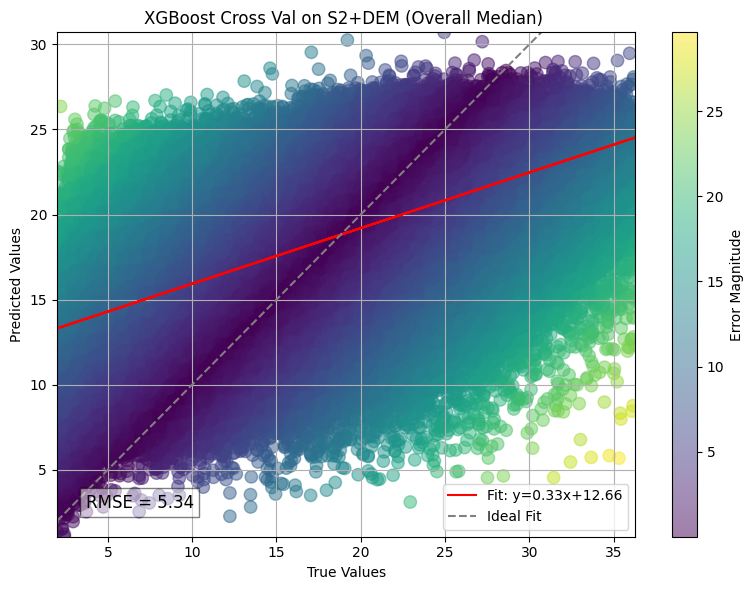

In [9]:
plot_reg_res('XGBoost Cross Val on S2+DEM (Overall Median) ',gt_df.values.flatten(), pred_df.values.flatten())